<a href="https://colab.research.google.com/github/joaramirezra/Mineral-Border-Dectetion/blob/Docs/Suavizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proceso de suavizado de imagenes 

In [88]:
#@markdown # Importar librerias
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import requests
import io
from matplotlib import pyplot as plt

In [89]:
#@markdown # Cargar funciones

def print_images(*images):
  subplots = len(images)

  plt.figure(figsize=(15,5))
  for i,img in enumerate(images) :
    plt.subplot(1,subplots,(i+1))
    plt.imshow(img,interpolation='none')
  plt.grid(0)
  plt.show()

def img_color_channel_change(img):  
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # HSV hue-saturation-value
  img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  # HSL hue-saturation-lightness
  img_hsL = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
  # YCBCR
  img_YBR = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
  
  return img_hsv,img_hsL,img_YBR,img_gray

def blurring_and_thresholding(img,color, diametro):
  kernel = np.ones((3,3),np.uint8)
  
  meanshift = cv2.pyrMeanShiftFiltering(img,sp=color,sr=diametro)
  
  laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=3 )
  laplacian = cv2.convertScaleAbs(laplacian)

  closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)
  
  _, binary = cv2.threshold(closing,127,255,cv2.THRESH_BINARY)

  return meanshift,laplacian,binary


def countour_draw(img2,real):
  w, h ,x= real.shape
  original = np.ones((w, h,x ), dtype="uint8")*255
  gray_scale =  cv2.cvtColor( img2 , cv2.COLOR_BGR2GRAY )
  cnts = cv2.findContours(gray_scale, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  
  counter = 0
  
  for c in cnts:
    area = cv2.contourArea(c)
    if area > 50:
      counter += 1
      cv2.drawContours(original,[c], 0, ( 200, 0, 128 ), 2)
  
  print("numero de granos encontrados : " , counter)
  original = cv2.addWeighted(real,0.4,original,0.6,0)
  
  return original

def tresholding(img):
  laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=3 )
  laplacian = cv2.convertScaleAbs(laplacian)
  laplacian = cv2.cvtColor(laplacian,cv2.COLOR_BGR2GRAY)

  closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)
   
  _, binary = cv2.threshold(closing,127,255,cv2.THRESH_BINARY)

  return binary 
  

# Cargar imagenes 

---
- descargar
- descomprimir


In [90]:
# !wget https://github.com/joaramirezra/Mineral-Border-Dectetion/raw/main/images/minerals.zip
# !unzip minerals.zip
# !ls

# Proceso individual 

 - Cargar imagen 
 - Realizar cambio de color 
 - Suavizado y umbralizado
 - Dibujar Contornos

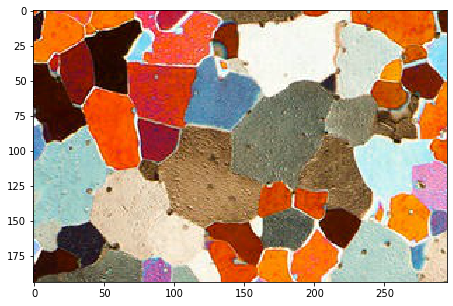

In [91]:
tipo = "3" #@param ["1", "2", "3"]
muestra = 11 #@param {type:"slider", min:1, max:15, step:1}
path = 'type'+tipo+"/Muestra"+str(muestra)+".png"
img = cv2.imread(path)
print_images(img)

# Cambio de color 

---


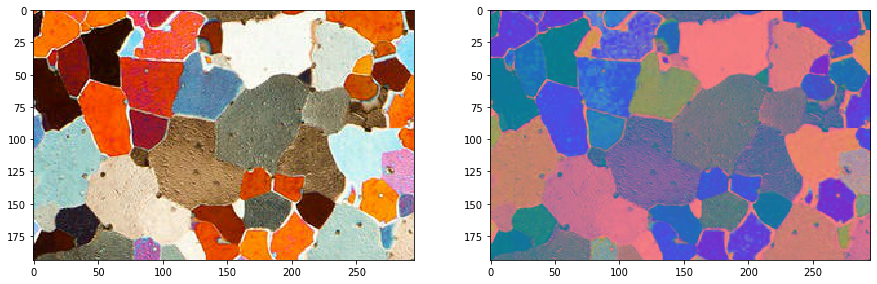

In [92]:
list_channels = img_color_channel_change(img)
color_channel = [ "hsv", "Hsi","YCBCR"]

tipo = "YCBCR" #@param [ "hsv", "Hsi","YCBCR"]
index = color_channel.index(tipo)
img_to_work = list_channels[index]
print_images(img, list_channels[index])

----

# Filtro Gaussiano 


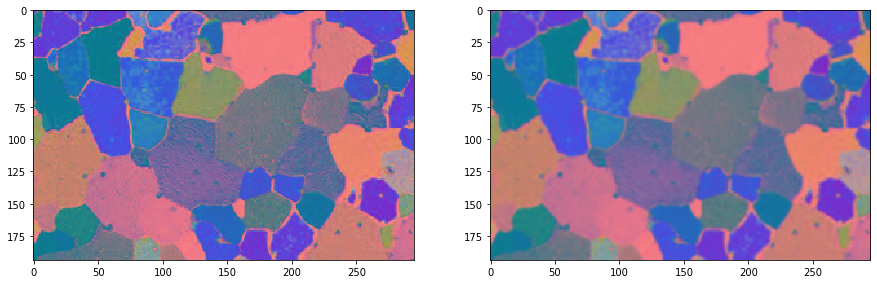

In [93]:
kernel_size = 3 #@param {type:"slider", min:1, max:7, step:2}
blur = cv2.GaussianBlur(img_to_work,(kernel_size,kernel_size),0,)
print_images(img_to_work,blur)

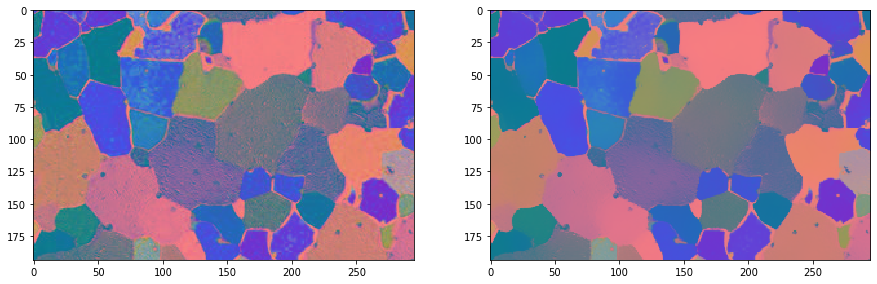

In [94]:
#@markdown ---
#@markdown  # **Parametros filtro bilateral**
 
vecinos =  20#@param {type:"integer"}
sigmaColor =  30#@param {type:"integer"}
sigmaSpace =  30#@param {type:"integer"}

blur = cv2.bilateralFilter(img_to_work,vecinos,sigmaColor,sigmaSpace)
print_images(img_to_work,blur)


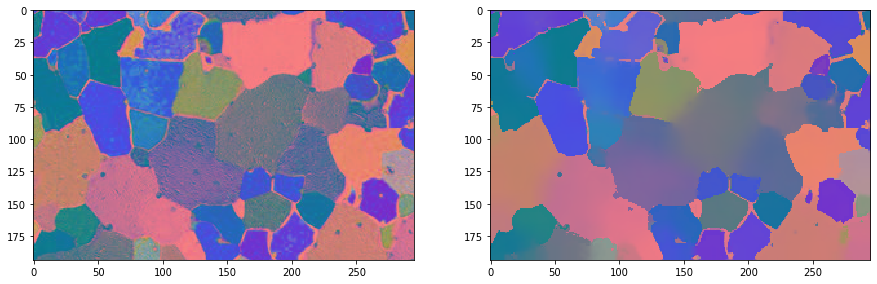

In [95]:
#@markdown ---
#@markdown  # **Parametros Filtro Mean-shift**
 
Rcolor =  10#@param {type:"integer"}
Rdiametro =  50#@param {type:"integer"}

blur = cv2.pyrMeanShiftFiltering(img_to_work,sp=Rcolor,sr=Rdiametro)

print_images(img_to_work,blur)


# Suavizado y umbralizado meanshift variando parametros 
---

In [101]:
#@markdown # **Deteccion automatica bordes Filtro Gaussiano**

def tresholding(img):

  img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) 
  kernel = np.ones((3,3),np.uint8)
  canny = cv2.Canny(img,75,150)
  _, binary = cv2.threshold(canny,127,255,cv2.THRESH_BINARY_INV)

  return binary 

kernels = [1,3,5,7]

for kernel in kernels :  
  print('Tamaño del kernel : ',kernel)
  blur = cv2.GaussianBlur(img_to_work,(kernel,kernel),0,)
  threshold_img = tresholding(blur)
  print_images(img_to_work,blur,threshold_img,
               countour_draw(threshold_img,img)
               )


Tamaño del kernel :  1


error: ignored

In [98]:
loaded_images = list()
for i in range (5,80,20):
  for j in range (5,80,20):
    meanshift,laplacian,binary = blurring_and_thresholding(img_to_work,i,j)
    threshold_img = tresholding(meanshift)
    print('sp : ',i,' , sr :', j)
    print_images(img_to_work,meanshift,threshold_img,countour_draw(threshold_img,img))
    

sp :  5  , sr : 5


error: ignored

In [ ]:
#@markdown #Some code to show the matriz of values
# print_images(loaded_images[0],loaded_images[1],loaded_images[2],loaded_images[3])
# print_images(loaded_images[4],loaded_images[5],loaded_images[6],loaded_images[7])
# print_images(loaded_images[8],loaded_images[9],loaded_images[10],loaded_images[1])
# print_images(loaded_images[12],loaded_images[13],loaded_images[14],loaded_images[15])

# print_images(loaded_images[16],loaded_images[17],loaded_images[18],loaded_images[19])
# print_images(loaded_images[20],loaded_images[21],loaded_images[22],loaded_images[23])
# print_images(loaded_images[24],loaded_images[25],loaded_images[26],loaded_images[27])
# print_images(loaded_images[28],loaded_images[29],loaded_images[30],loaded_images[31])

---
---

# Dummy code



In [ ]:
# kernel = np.ones((3,3),np.uint8)
  
# meanshift = cv2.pyrMeanShiftFiltering(img,sp=18,sr=50)

# laplacian = cv2.Laplacian(meanshift,ddepth = cv2.CV_64FC3, ksize=3 )
# laplacian = cv2.convertScaleAbs(laplacian)

# laplacian = cv2.cvtColor(laplacian,cv2.COLOR_BGR2GRAY)
# ret3,th3 = cv2.threshold(laplacian,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel)

# _, binary = cv2.threshold(closing,127,255,cv2.THRESH_BINARY)


# print_images(img, meanshift,laplacian,th3)
# print_images(closing,binary)



In [ ]:
# [print_images(loaded_images[i]) for i in range (16)]

In [ ]:
# meanshift = cv2.pyrMeanShiftFiltering(img,sp=7,sr=40)

# filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# filter2 = np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])

# # Applying cv2.filter2D function on our Cybertruck image
# sharpen_img_1=cv2.filter2D(meanshift,-1,filter)
# sharpen_img_2=cv2.filter2D(meanshift,-1,filter2)

# meanshift2 = cv2.pyrMeanShiftFiltering(sharpen_img_1,sp=7,sr=40)


# print_images(img,meanshift,sharpen_img_1)


# kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

# meanshift2 = cv2.filter2D(meanshift, -1,kernel)


# kernel = np.ones((3,3),np.uint8)
# closing = cv2.morphologyEx(meanshift2, cv2.MORPH_CLOSE, kernel)
# kernel = np.ones((3,3),np.uint8)
# erosion = cv2.erode(closing,kernel,iterations = 1)


# canny = cv2.Canny(erosion,150,200)


# print_images(img,canny)



In [ ]:

meanshift = cv2.pyrMeanShiftFiltering(img,sp=7,sr=40)

filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
filter2 = np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])

# Applying cv2.filter2D function on our Cybertruck image
sharpen_img_1=cv2.filter2D(meanshift,-1,filter)
sharpen_img_2=cv2.filter2D(meanshift,-1,filter2)

meanshift2 = cv2.pyrMeanShiftFiltering(sharpen_img_1,sp=7,sr=40)


kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(meanshift2, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(closing,kernel,iterations = 2)


canny = cv2.Canny(erosion,150,200)
laplacian = cv2.Laplacian(meanshift2,ddepth = cv2.CV_8U, ksize=3 )
laplacian = cv2.convertScaleAbs(laplacian)

print_images(img,meanshift)
print_images(sharpen_img_1,sharpen_img_2)
print_images(meanshift,meanshift2)
print_images(laplacian,canny)



meanshift,laplacian,binary = blurring_and_thresholding(img,7,20)
print_images(countour_draw(binary,img))

In [ ]:
# kernel = np.ones((5,5),np.uint8)

# laplacian = cv2.Laplacian(meanshift2,ddepth = cv2.CV_64FC3, ksize=3 )
# laplacian = cv2.convertScaleAbs(laplacian)

# closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)
# kernel = np.ones((3,3),np.uint8)
# erosion = cv2.erode(closing,kernel,iterations = 2)


# _, binary = cv2.threshold(erosion,127,255,cv2.THRESH_BINARY)

# print_images(meanshift2,laplacian,binary)
